<a href="https://colab.research.google.com/github/CubatLin/Shopee-Code-League-2020-Competition-2--Open-Product-Detection-baseline-over-0.8/blob/master/ShopeeCodeLeague2021_DataAnalytics_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Team: 台灣鬼滅之刃線上看
* Solution by Darren, compile by Ethan

In [ ]:
def import_data_from_drive(id):
  !wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{id} -O- \
  | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt && wget --content-disposition --load-cookies cookies.txt 'https://docs.google.com/uc?export=download&id='{id}'&confirm='$(<confirm.txt)

In [ ]:
%%time
import_data_from_drive('1sWQmlq9-CPfos1TOqiBxigN0BmPVr7Hs')

--2021-08-03 05:48:14--  https://docs.google.com/uc?export=download&id=1sWQmlq9-CPfos1TOqiBxigN0BmPVr7Hs
Resolving docs.google.com (docs.google.com)... 173.194.218.138, 173.194.218.139, 173.194.218.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.218.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fg0n97r4mge8veo07j70rvmalvgv6qmr/1627969650000/12626892632851982799/*/1sWQmlq9-CPfos1TOqiBxigN0BmPVr7Hs?e=download [following]
--2021-08-03 05:48:15--  https://doc-14-94-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fg0n97r4mge8veo07j70rvmalvgv6qmr/1627969650000/12626892632851982799/*/1sWQmlq9-CPfos1TOqiBxigN0BmPVr7Hs?e=download
Resolving doc-14-94-docs.googleusercontent.com (doc-14-94-docs.googleusercontent.com)... 173.194.217.132, 2607:f8b0:400c:c13::84
Connecting to doc-14-94-docs.googleusercontent.com (doc-14

In [ ]:
import pandas as pd
import numpy as np

data = pd.read_json('/content/contacts.json')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Id        500000 non-null  int64 
 1   Email     500000 non-null  object
 2   Phone     500000 non-null  object
 3   Contacts  500000 non-null  int64 
 4   OrderId   500000 non-null  object
dtypes: int64(2), object(3)
memory usage: 19.1+ MB


In [ ]:
data.head()

,Id,Email,Phone,Contacts,OrderId
0,0,gkzAbIy@qq.com,,1,
1,1,,329442681752,4,vDDJJcxfLtSfkooPhbYnJdxov
2,2,,9125983679,0,
3,3,mdllpYmE@gmail.com,,0,bHquEnCbbsGLqllwryxPsNOxa
4,4,,300364407,2,


In [ ]:
data['Phone'][0]

''

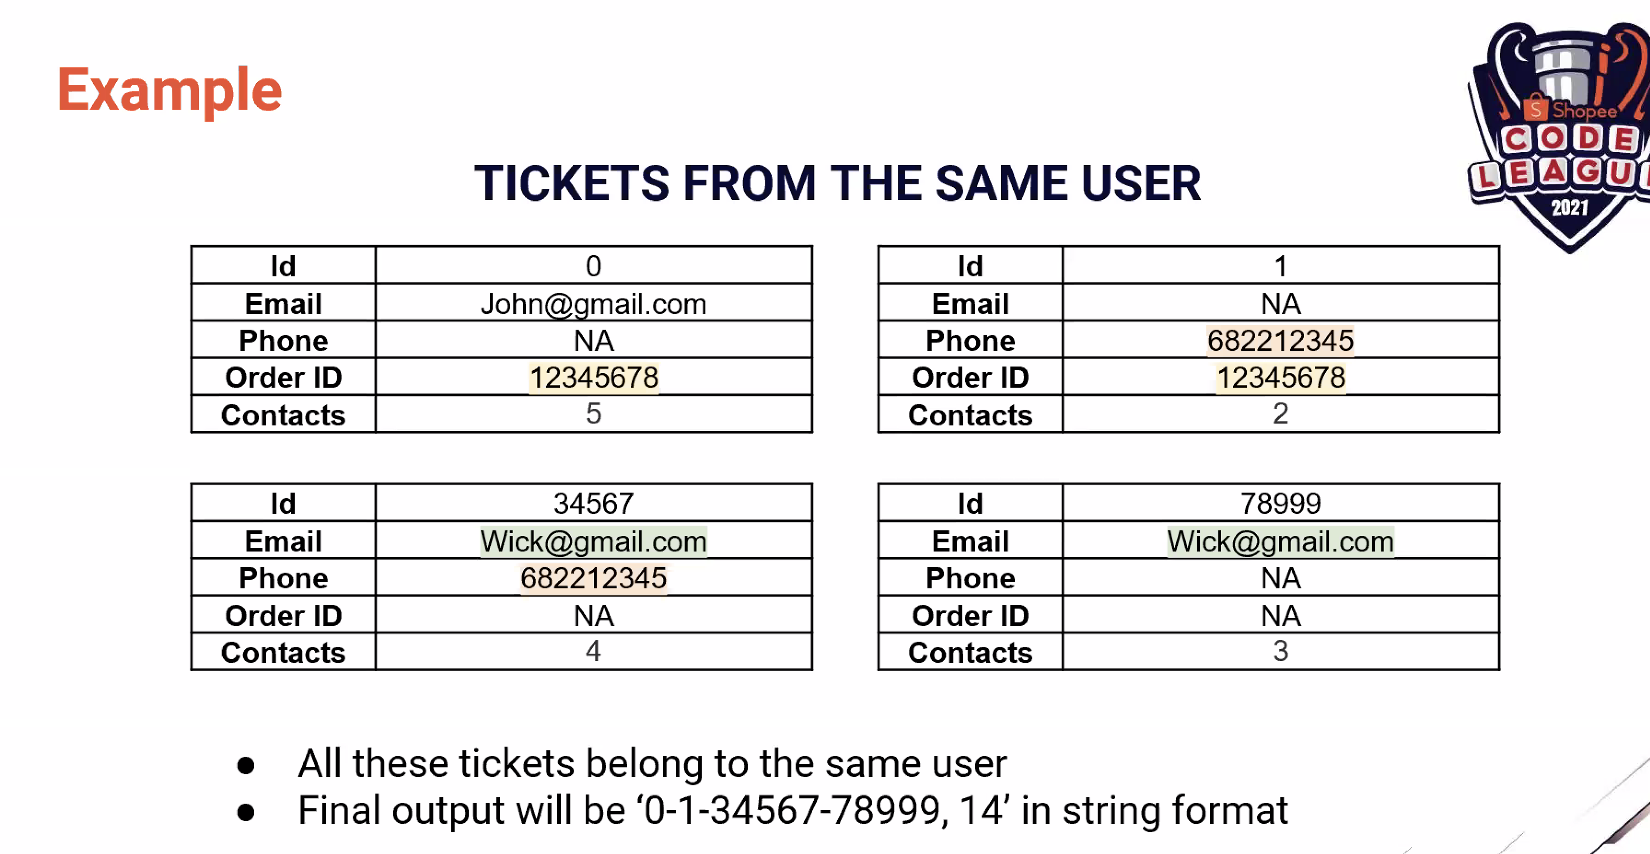

### 步驟
1. 對所有ticket, 用Email, OrderId, Phone找出有直接關係的其他ticket
2. 對所有ticket, 整理出有直接關係的ticket list
3. 對所有ticket 的 ticket list的每個element, depth-first-search找出所有有間接關係的ticket  (這一步我順便做了答案要的ticket_trace)
4. data.groupby(ticket_trace).sum(Contacts)

In [ ]:
data.loc[data.Email != '', :].groupby(['Email'])['Id'].apply(list).reset_index()

,Email,Id
0,AAAQbNfGbLAeOvw@hotmail.com,"[112387, 470075]"
1,AAAgyKTteOjasN@qq.com,[338154]
2,AABZmKeEldvO@gmail.com,[426495]
3,AABneiGcqcz@qq.com,[37868]
4,AABtOIZmdYdKGnidAK@yahoo.com,[137956]
...,...,...
249151,zzyYjbPWM@hotmail.com,"[143089, 338473]"
249152,zzyacSRLb@gmail.com,[425119]
249153,zzylmjkoqfCkTOxi@hotmail.com,[146556]
249154,zzyvKfCcQWPJdShGoItP@hotmail.com,"[381064, 458030]"


In [ ]:
# group by email, orderId, phone separately, append Id to list
list_email = data.loc[data.Email != '', :].groupby(['Email'])['Id'].apply(list).reset_index()
list_orderid = data.loc[data.OrderId != '', :].groupby(['OrderId'])['Id'].apply(list).reset_index()
list_phone = data.loc[data.Phone != '', :].groupby(['Phone'])['Id'].apply(list).reset_index()

In [ ]:
# rename columns for merging
list_email.columns = ['Email', 'Id_email']
list_orderid.columns = ['OrderId', 'Id_order']
list_phone.columns = ['Phone', 'Id_phone']

In [ ]:
# merge with data, left join on condition
data = data.merge(list_email, on='Email', how='left')
data = data.merge(list_orderid, on='OrderId', how='left')
data = data.merge(list_phone, on='Phone', how='left')

In [ ]:
data.head()

,Id,Email,Phone,Contacts,OrderId,Id_email,Id_order,Id_phone
0,0,gkzAbIy@qq.com,,1,,[0],NaN,NaN
1,1,,329442681752,4,vDDJJcxfLtSfkooPhbYnJdxov,NaN,"[1, 2458, 476346]",[1]
2,2,,9125983679,0,,NaN,NaN,"[2, 348955]"
3,3,mdllpYmE@gmail.com,,0,bHquEnCbbsGLqllwryxPsNOxa,[3],[3],NaN
4,4,,300364407,2,,NaN,NaN,[4]


In [ ]:
# replace NaN with empty list
data['Id_email'] = data['Id_email'].fillna('').apply(list)
data['Id_order'] = data['Id_order'].fillna('').apply(list)
data['Id_phone'] = data['Id_phone'].fillna('').apply(list)

In [ ]:
data.head()

,Id,Email,Phone,Contacts,OrderId,Id_email,Id_order,Id_phone
0,0,gkzAbIy@qq.com,,1,,[0],[],[]
1,1,,329442681752,4,vDDJJcxfLtSfkooPhbYnJdxov,[],"[1, 2458, 476346]",[1]
2,2,,9125983679,0,,[],[],"[2, 348955]"
3,3,mdllpYmE@gmail.com,,0,bHquEnCbbsGLqllwryxPsNOxa,[3],[3],[]
4,4,,300364407,2,,[],[],[4]


In [ ]:
# append three lists
data['Id_list'] = data['Id_email'] + data['Id_order'] + data['Id_phone']

In [ ]:
# eliminate dulicates, format to string for submission
data['Id_str'] = data['Id_list'].apply(lambda x: '-'.join([str(Id) for Id in sorted(set(x))]))

In [ ]:
# peek
data.head()

,Contacts,Email,Id,OrderId,Phone,Id_email,Id_order,Id_phone,Id_list,Id_str
0,1,gkzAbIy@qq.com,0,,,[0],[],[],[0],0
1,4,,1,vDDJJcxfLtSfkooPhbYnJdxov,329442681752,[],"[1, 2458, 476346]",[1],"[1, 2458, 476346, 1]",1-2458-476346
2,0,,2,,9125983679,[],[],"[2, 348955]","[2, 348955]",2-348955
3,0,mdllpYmE@gmail.com,3,bHquEnCbbsGLqllwryxPsNOxa,,[3],[3],[],"[3, 3]",3
4,2,,4,,300364407,[],[],[4],[4],4


In [ ]:
# distinct Id_list with direct relationship
data['Id_dlist'] = data['Id_list'].apply(lambda x: sorted(set(x)))

In [ ]:
# Find all indirect relationship via DFS with cache and early termination
d = {}
def search(id_list, d):
    if len(id_list) == 1:
        return str(id_list[0])
    for Id in id_list:
        if Id in d:
            return d[Id]
    s = set(id_list)
    search = id_list[:]
    while search:
        Id = search.pop()
        for l in data.loc[data.Id == Id, 'Id_dlist']:
            for new_id in l:
                if new_id not in s:
                    s.add(new_id)
                    search.append(new_id)
    ans = '-'.join([str(Id) for Id in sorted(list(s))])
    for Id in s:
        d[Id] = ans
    return ans

data['Id_str'] = data['Id_dlist'].apply(lambda x: search(x, d))

In [ ]:
# deprecated

# def search(id_list):
#     s = set(id_list)
#     search = id_list[:]
#     while search:
#         Id = search.pop()
#         for l in data.loc[data.Id == Id, 'Id_dlist']:
#             for new_id in l:
#                 if new_id not in s:
#                     s.add(new_id)
#                     search.append(new_id)
#     return '-'.join([str(Id) for Id in sorted(list(s))])

# data['Id_str'] = data['Id_dlist'].apply(search)

In [ ]:
# sum contact by grouping with the Id_str 
contact_sum = data.groupby('Id_str')['Contacts'].sum().reset_index()
contact_sum.columns = ['Id_str', 'contact_sum']
data = pd.merge(data, contact_sum, on="Id_str", how='left')

In [ ]:
# concat output
data['ticket_trace/contact'] = data['Id_str'] + ', ' + data['contact_sum'].apply(str)

In [ ]:
# construct ans df
ans = data[['Id', 'ticket_trace/contact']]
ans.columns = ['ticket_id', 'ticket_trace/contact']
ans = ans.sort_values('ticket_id').reset_index(drop=True)

In [ ]:
ans.to_csv('answer_darren.csv', index=False)  